In [1]:
import subprocess
from rpy2.robjects import r
from rc_data_preparation import RcDataPreparation
from rc_pred_ann_model import PredAnnModel

current_data = RcDataPreparation()

def get_genes_list(p_thresh, split_train):
    # Define the R script path
    r_script = "rc_get_diff_genes.r"
    
    # Build the command to run the R script
    command = ["Rscript", r_script, str(p_thresh), str(split_train)]
    
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check if the R script ran successfully
    if result.returncode == 0:
        print("R script executed successfully.")
    
        # Read the generated file
        rds_path = '/tmp/work/RCproject_code/sean_ann_python/ann_gene_set.rds'
        current_genes = r.readRDS(rds_path)
        print(len(current_genes))
        
    else:
        print("Error in R script execution:")
        print(result.stderr)

    return(current_genes.tolist())

current_genes = get_genes_list(0.1, True)
# current_model = PredAnnModel(current_data,current_genes)

2025-01-23 13:57:00.375440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians,

Data successfully loaded.
R script executed successfully.
910


In [2]:
current_gene_list = 'de_intersect_plus_bulk_genes'

# Load the RDS file
rds_path = '/tmp/work/RCproject/gene_lists.rds'
rds_data = r.readRDS(rds_path)

# Extract the names of the lists and their contents
gene_lists = {}
for name, item in zip(rds_data.names, rds_data):
    # Each 'item' is a list associated with the 'name'
    inner_list = list(item)  # Convert the inner R list to a Python list
    gene_lists[name] = inner_list

# Now `python_data` is a dictionary with names as keys and lists as values
print(gene_lists.keys())

current_genes = gene_lists[current_gene_list]

print(len(current_genes))

dict_keys(['meta', 'DE4', 'DEall', 'meta_intersect_unionDE', 'de_intersect', 'de_intersect_plus_bulk_genes', '5k', 'CV', 'CV300', 'CV300_4MA', 'Boruta_4MA', 'Boruta_6', 'CVBig', 'final300', 'final350', 'final', 'sig_4_6_0.05', 'sig_4_6_0.1', 'sig9_0.05', 'sig9_0.01', 'sig9', 'GEOMX_4_6_0.05_'])
366


In [3]:
current_model = PredAnnModel(current_data,current_genes)

Epoch 0, Average Outcome Loss: 0.7027639421549711, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3659
Epoch 100, Average Outcome Loss: 0.6933172941207886, Average Accuracy: 0.48863636363636365, Test AUC: 0.4308, Test Accuracy: 0.3659
Epoch 200, Average Outcome Loss: 0.7004008184779774, Average Accuracy: 0.5, Test AUC: 0.4077, Test Accuracy: 0.6341
Epoch 300, Average Outcome Loss: 0.6920159242369912, Average Accuracy: 0.5, Test AUC: 0.4667, Test Accuracy: 0.6341
Epoch 400, Average Outcome Loss: 0.641482022675601, Average Accuracy: 0.7215909090909091, Test AUC: 0.7744, Test Accuracy: 0.7073


In [4]:
test_accuracy_list = current_model.test_accuracy_list # list of metrics for evaluating the model
test_auc_list = current_model.test_auc_list # list of metrics for evaluating the model
train_accuracy_list = current_model.train_accuracy_list # list of metrics for evaluating the model

print(max(test_accuracy_list))
print(max(test_auc_list))
print(max(train_accuracy_list))

tf.Tensor(0.75609756, shape=(), dtype=float32)
0.8128205128205128
0.8011363636363636


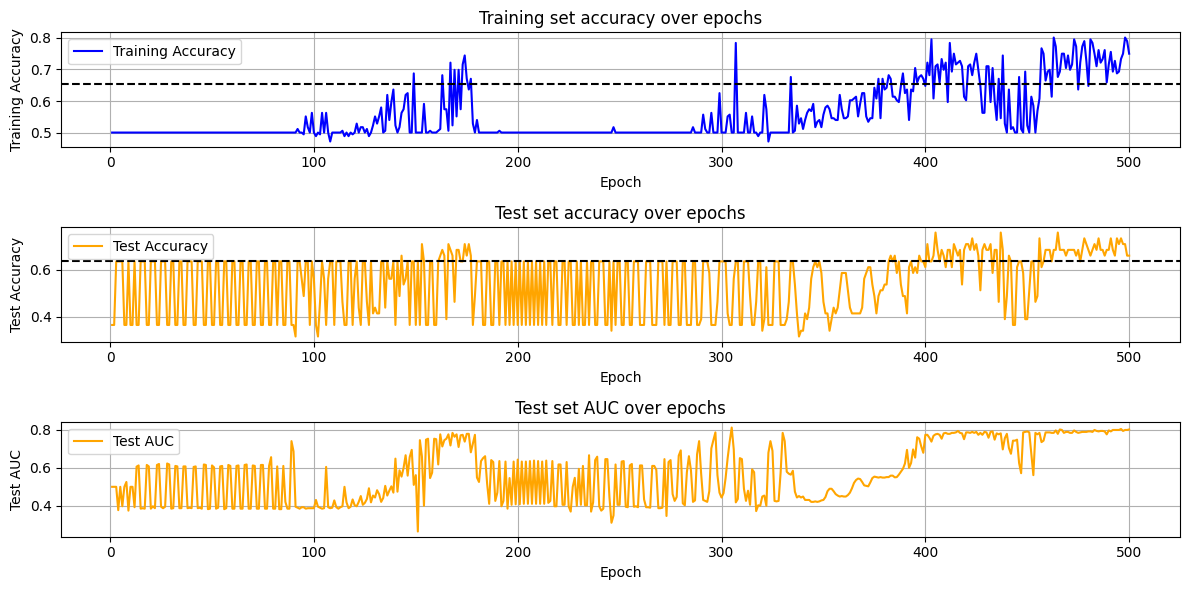

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# After training, plot the metrics

frequency_counts = pd.Series(current_data.y_test_outcome).value_counts()
test_chance_level = frequency_counts[0]/len(current_data.y_test_outcome)

frequency_counts = pd.Series(current_data.y_train_outcome).value_counts()
train_chance_level = frequency_counts[0]/len(current_data.y_train_outcome)

fig, axs = plt.subplots(3, 1, figsize=(12, 6))

x_values = np.arange(1, len(train_accuracy_list) + 1) * current_model.report_frequency

# Plot train accuracy
axs[0].plot(x_values, train_accuracy_list, label='Training Accuracy', color='blue')
axs[0].axhline(train_chance_level, color='black',linestyle ='--')
axs[0].set_title('Training set accuracy over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Accuracy')
axs[0].grid()
axs[0].legend()

# Plot test accuracay
axs[1].plot(x_values, test_accuracy_list, label='Test Accuracy', color='orange')
axs[1].axhline(test_chance_level, color='black',linestyle ='--')
axs[1].set_title('Test set accuracy over epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Test Accuracy')
axs[1].grid()
axs[1].legend()

# Plot test accuracay
axs[2].plot(x_values, test_auc_list, label='Test AUC', color='orange')
# axs[2].axhline(0.5, color='black',linestyle ='--')
axs[2].set_title('Test set AUC over epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Test AUC')
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()